## Sentiment analysis of the State of the Union addresses of Barack Obama in 2010 and Donald Trump in 2018 using the VADER pretrained model in NLTK.

### Let's start importing some useful packages

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
%matplotlib inline

### Now initialize sentiment intensity analyzer instance

In [3]:
sid = SentimentIntensityAnalyzer()

### Let's test out the sentiment analyzer with a couple of sentences:

In [4]:
paragraph = '''
The car is old.
The car is broken.
The old car is broken.
We strengthened our laws to protect against hate. 
We finally strengthened our laws to protect against hate. 
We finally strengthened our laws to protect against crimes driven by hate.'''

sentences = paragraph.split('.')[:-1] #[:-1] to remove last sentence containing only a period

for sentence in sentences:
    print sentence + '.', "\n", sid.polarity_scores(sentence)


The car is old. 
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

The car is broken. 
{'neg': 0.508, 'neu': 0.492, 'pos': 0.0, 'compound': -0.4767}

The old car is broken. 
{'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'compound': -0.4767}

We strengthened our laws to protect against hate. 
{'neg': 0.262, 'neu': 0.355, 'pos': 0.383, 'compound': 0.1779}
 
We finally strengthened our laws to protect against hate. 
{'neg': 0.245, 'neu': 0.397, 'pos': 0.358, 'compound': 0.1779}
 
We finally strengthened our laws to protect against crimes driven by hate. 
{'neg': 0.204, 'neu': 0.497, 'pos': 0.298, 'compound': 0.1779}


### Okay, that worked. We see that as more negative words were added to the sentences, the scores changed accordingly.

### So now that the simple test worked, let's get real and load the Presidents' speeches!

In [5]:
# Load Obama's speech
Obama_file = "./textfiles/SoU_Obama2010.txt"
f = open(Obama_file, 'r')
Obama_speech = f.read()
f.close()

In [6]:
# Load Trump's speech
Trump_file = "./textfiles/SoU_Trump2018.txt"
f = open(Trump_file, 'r')
Trump_speech = f.read()
f.close()

### Here I define a few functions to clean up text, analyze sentiments, and generate plots.

In [7]:
def cleanup_text(text):
    '''
    Clean up text.
     1) Remove spaces before and after line breaks
     2) Remove double line breaks
     3) Remove line breaks from top of text
     
    Parameters
    -----------
     - text (str): input text
      
    Returns
    -----------
     - text (str): cleaned text
     '''
    
    
    try:
        
        # 1)
        while ' \n' in text:
            text = text.replace(' \n', '\n')
        while '\n ' in text:
            text = text.replace('\n ', '\n')
        
        # 2) 
        while '\n\n' in text:
            text = text.replace('\n\n', '\n')

        
        # 3)
        while text.startswith('\n'):
            text = text.lstrip()
        
        
        return text


    except:
        print 'ERROR: text is not a string'
    


def split_text(text, sep):
    '''
    Split text into a list of "sentences" as determined by the delimiter sep.
    
    Parameters
    -----------
     - text (str): text to be split.
     - sep (str) : sentence separator.
     
    Returns
    -----------
     - sentences (list): list of strings containing all "sentences" 
                         in text as determined by sep. 
    '''


    if sep != '\n':
        sentences = text.replace('\n', '').split(sep)[:-1] # [:-1] to eliminate empty string at end of text.
    else:
        sentences = text.replace('\n\n', '\n').split(sep)
    
    # Remove empty space in the beginning of each sentence preceded by sep
    sentences = [s.lstrip() if s[0] == ' ' else s for s in sentences] 
    
    
    return sentences

In [8]:
def analyze_sentiment(sid, sentences):
    '''
    Analyze the sentiment of a group of "sentences" with the
    VADER class of the NLTK package.
    
    Parameters
    -----------
     - sid: nltk.sentiment.vader.SentimentIntensityAnalyzer object
     - sentences: list of sentences to be analyzed
     
    Returns
    -----------
     - sentiment: dict of lists containing the sentiment scores. Keywords
                  are 'neg', 'neu', 'pos', and 'compound'.
    '''
    
    # Create dict of empty lists
    sentiment = {
        'neg' : [],
        'neu' : [],
        'pos' : [],
        'compound' : []
    }
    
    # Loop over all sentences; evaluate sentiment; append scores to lists
    for sentence in sentences:
        res = sid.polarity_scores(sentence)
        sentiment['neg'].append(res['neg'])
        sentiment['neu'].append(res['neu'])
        sentiment['pos'].append(res['pos'])
        sentiment['compound'].append(res['compound'])

    
    return sentiment

In [9]:
def plot_compound(
    compound,
    title,
    xlabel = 'sentence number',
    ylabel = 'compound score'):
    '''
    Plot scores.
    '''
    
    plt.figure(figsize=(9,3))
    plt.plot(compound)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show();
    

def sentiment_histograms(
    O_score, 
    T_score, 
    Nbins=9, 
    xmin=-1.0, 
    xmax=1.0,
    xlabel='sentiment score',
    ylabel='normalized freq. diff.',
    title='Scores on text partitions.'):
    
    '''
    Plot histograms of 2 different sentiment scores
    
    Parameters
    -----------
    O_score, T_score : sentiment scores. Can be of type tuple, list, or np.array
    Nbins : number of bins in histogram
    xmin, xmax : min and max values for scores
    xlabel, ylabel, title : plot labels and titles
    '''

    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_size_inches(w=12, h=4)
    
    O_hist = ax1.hist(
        O_score, 
        Nbins,
        range=(xmin, xmax),
        normed=True, 
        alpha=0.7,
        label='Obama2010')

    T_hist = ax1.hist(
        T_score, 
        Nbins, 
        range=(xmin, xmax),
        normed=True, 
        alpha=0.35,
        label='Trump2018')

    ax1.set_xlabel('compound sentiment score')
    ax1.set_ylabel('normalized frequency')
    ax1.set_title(title)
    ax1.legend()
    
    
    # Create histogram difference
    diff = O_hist[0] - T_hist[0]
    pos = diff >= 0 # Obama > Trump
    neg = diff <= 0 # Trump > Obama

    bincenters = 0.5*(T_hist[1][:-1] + T_hist[1][1:])
    binwidths  = T_hist[1][1:]-T_hist[1][:-1]

    ax2.bar(
        bincenters,
        diff*pos,
        width = binwidths,
        color = 'b',
        label = 'Obama2010 dominates');

    ax2.bar(
        bincenters,
        diff*neg,
        width = binwidths,
        color = 'r',
        label = 'Trump2018 dominates');

    ax2.set_xlabel('compound sentiment score')
    ax2.set_ylabel('normalized freq. diff. (Obama-Trump)')
    ax2.set_title(title)
    ax2.legend();
    
    
    
def list_avg(l):
    '''
    Compute the average of a list of numbers.
    
    Parameters
    -----------
     - l: list of numbers
     
    Returns
    -----------
     - average
    '''

    if len(l) == 0:
        return 0
    else:
        return sum(l)/len(l)



def report_avg_sentiment(sentiment, title=None):
    '''
    Print out report of average sentiment scores.
    
    Parameters
    -----------
     - sentiment: dict of lists containing sentiment scores.
     - title, optional: title for the scores in sentiment
    '''
    
    
    if title is not None:
        print "         " + title
        
    print "Positivity:", list_avg(sentiment['pos'])
    print "Negativity:", list_avg(sentiment['neg'])
    print "Neutrality:", list_avg(sentiment['neu'])
    print "Compound  :", list_avg(sentiment['compound'])
    print ""

### Let's begin by splitting the texts into sentences and analyzing their sentiment.

In [10]:
# Compute sentiment sentencewise
Obama_sentences = split_text(cleanup_text(Obama_speech), sep='.')
Obama_s_sentiment = analyze_sentiment(sid, Obama_sentences)

Trump_sentences = split_text(cleanup_text(Trump_speech), sep='.')
Trump_s_sentiment = analyze_sentiment(sid, Trump_sentences)

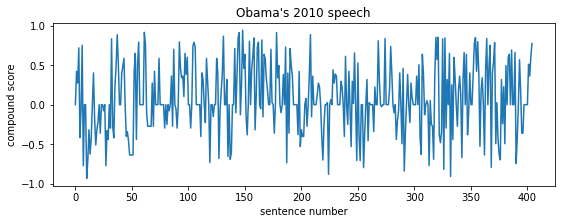

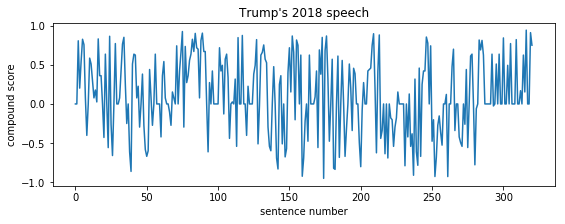

In [11]:
# Plot compound sentiment as a function of the sentence number
plot_compound(Obama_s_sentiment['compound'], """Obama's 2010 speech""")
plot_compound(Trump_s_sentiment['compound'], """Trump's 2018 speech""")

### One observation: Trump ends with very positive or neutral rant while Obama's speech changes sentiment all throughout...

### Let's look at all sentiment scores averaged over the entire speech:

In [26]:
# Average scores over the entire speech
report_avg_sentiment(Obama_s_sentiment, title='Obama')
report_avg_sentiment(Trump_s_sentiment, title='Trump')

         Obama
Positivity: 0.117
Negativity: 0.0901703703704
Neutrality: 0.790380246914
Compound  : 0.0739113580247

         Trump
Positivity: 0.13523364486
Negativity: 0.0761090342679
Neutrality: 0.788641744548
Compound  : 0.10890529595



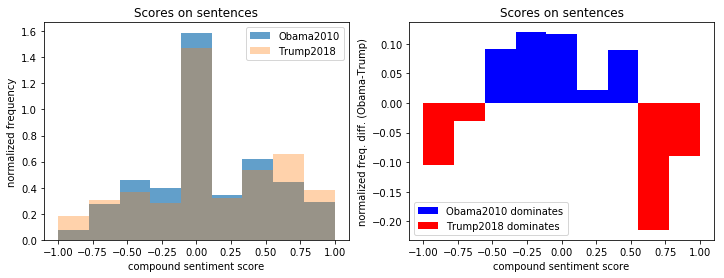

In [13]:
# Let's plot compound sentiment histograms
sentiment_histograms(
    Obama_s_sentiment['compound'],
    Trump_s_sentiment['compound'],
    xlabel='compound sentiment score',
    title='Scores on sentences')

### The average scores and the plot reveal two interesting facts:
####   1. Trump2018 is more positive than Obama2010
####   2. Trump2018's speech has a higher presence of extreme scores, while Obama2010's sentiment is more moderate in comparison.

## What if we separate the text by paragraphs instead of by sentences?

In [15]:
Obama_paragraphs = split_text(Obama_speech, '\n') # notice separator is now '\n'
Obama_p_sentiment = analyze_sentiment(sid, Obama_paragraphs)

Trump_paragraphs = split_text(Trump_speech, '\n')
Trump_p_sentiment = analyze_sentiment(sid, Trump_paragraphs)

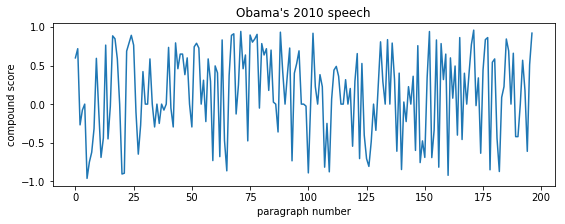

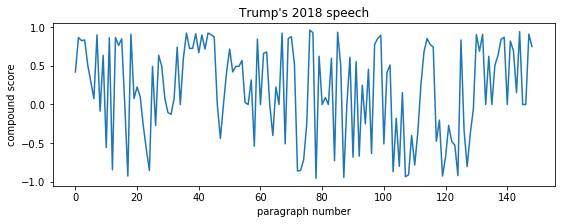

In [16]:
# Plot
plot_compound(Obama_p_sentiment['compound'], """Obama's 2010 speech""", xlabel = 'paragraph number',)
plot_compound(Trump_p_sentiment['compound'], """Trump's 2018 speech""", xlabel = 'paragraph number',)

In [17]:
# Average scores
report_avg_sentiment(Obama_p_sentiment, title='Obama')
report_avg_sentiment(Trump_p_sentiment, title='Trump')

         Obama
Positivity: 0.117756345178
Negativity: 0.0834568527919
Neutrality: 0.798822335025
Compound  : 0.142118781726

         Trump
Positivity: 0.150845637584
Negativity: 0.077677852349
Neutrality: 0.771503355705
Compound  : 0.19577114094



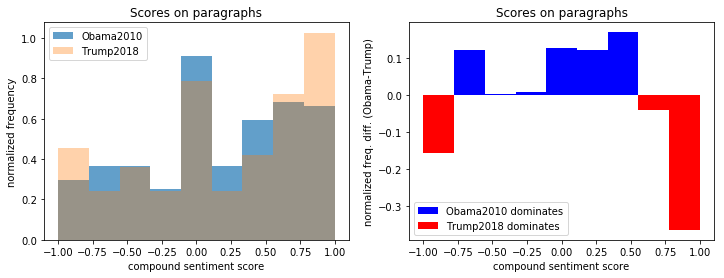

In [18]:
sentiment_histograms(
    Obama_p_sentiment['compound'],
    Trump_p_sentiment['compound'],
    xlabel='compound sentiment score',
    title='Scores on paragraphs')

### After splitting by paragraph, the qualitative conclusions of the sentence-wise analysis remain: Trump2018 uses more extreme language and is overall more positive than Obama2010. However, compound scores on paragraphs seem to show more acute values (very positive or very negative) than on sentences. 

### VADER was trained on 800 tweets. These typically range between 1 and 3 sentences in length, similar to the paragrahps in both Presidents' speeches. For that reason, it is intuitive to think that the analysis on paragraphs is likely more truthful to the sentiment on the whole text than that on sentences. 

### A validation of this hypothesis is left for the future. One possible way to go about it would be to manually score a group of paragraphs and their composing sentences and check on which text VADER better represents the human scores. 

## And what if we aggregate N=3 paragraphs together?

In [27]:
N=3
lag=0

In [20]:
# Join every N paragraphs
Obama_Np = [' '.join(Obama_paragraphs[lag+i:lag+i+N]) for i in range(0,len(Obama_paragraphs)-lag,N)]
Trump_Np = [' '.join(Trump_paragraphs[lag+i:lag+i+N]) for i in range(0,len(Trump_paragraphs)-lag,N)]

In [21]:
Obama_Np_sentiment = analyze_sentiment(sid, Obama_Np)
Trump_Np_sentiment = analyze_sentiment(sid, Trump_Np)

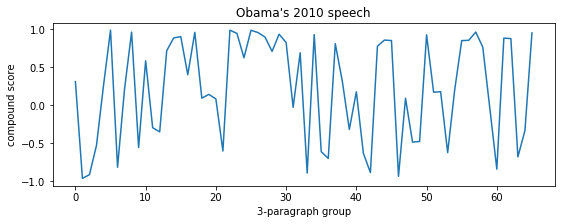

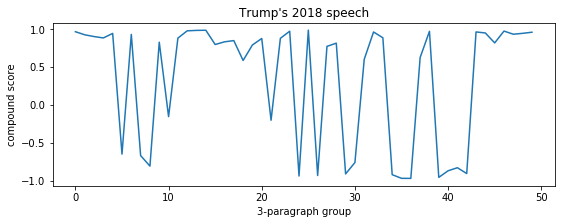

In [22]:
# Plot
plot_compound(Obama_Np_sentiment['compound'], """Obama's 2010 speech""", xlabel = str(N)+'-paragraph group',)
plot_compound(Trump_Np_sentiment['compound'], """Trump's 2018 speech""", xlabel = str(N)+'-paragraph group',)

In [23]:
report_avg_sentiment(Obama_Np_sentiment, title='Obama')
report_avg_sentiment(Trump_Np_sentiment, title='Trump')

         Obama
Positivity: 0.127363636364
Negativity: 0.0854545454545
Neutrality: 0.787121212121
Compound  : 0.227293939394

         Trump
Positivity: 0.15788
Negativity: 0.08362
Neutrality: 0.75856
Compound  : 0.349878



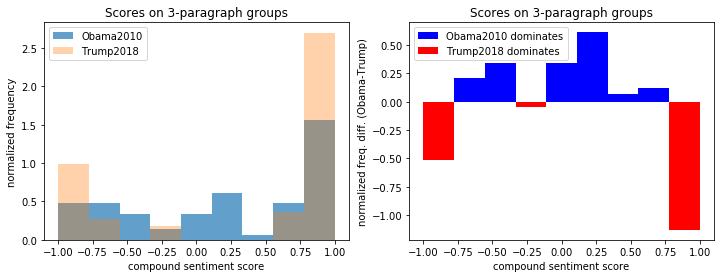

In [24]:
sentiment_histograms(
    Obama_Np_sentiment['compound'],
    Trump_Np_sentiment['compound'],
    xlabel='compound sentiment score',
    title='Scores on '+str(N)+'-paragraph groups')

### We see that aggregating over 3 paragraphs further magnifies our conclusions that Trump2018 is more positive and more extreme than Obama2010. Interestingly, after this 3-paragraph aggregation the percentage of almost-neutral (between -0.25 and +0.25) text units has decreased severely. It is as if VADER counted positive/negative words but didn't normalize it by the size of the text unit. 

## Summary and future ideas

### We have performed a sentiment analysis of Obama 2010 and Trump 2018 State of the Union addresses using the VADER package of the NLTK library. We evaluated sentiment scores dividing the speeches into 3 text unit sizes: sentences, paragraphs and 3-paragraphs. All 3 cases show the same qualitative conclusions: 
1. Trump2018 has a very positive final stretch while Obama2010 fluctuates between positive and negative all throughout.
2. Trump2018 is overall more positive than Obama2010.
3. Trump2018 uses a more polarized (very positive and very negative) language than Obama2010.

### Some ideas to continue this preliminary study would be:
1. Validation of sentiment analysis for sentences, paragraphs, and 3-paragraphs by human-tagging.
2. Compare these addresses to similar addresses by other leaders.
3. Going big: are our conclusions about Trump's and Obama's language usage styles general or are there specific to these speeches? Collect a large corpus of speeches, press conferences, interviews, etc. and run a similar study.